In [28]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree
from scipy.misc import logsumexp

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from helpers import get_ext
from dustmaps.sfd import SFDQuery

from xdgmm import XDGMM

In [2]:
g = GaiaData('../data/LA-gaia-result.fits')
c = g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

In [33]:
EBV = SFDQuery().query(c)
A_gaia = get_ext(g.phot_g_mean_mag.value, 
                 g.phot_bp_mean_mag.value,
                 g.phot_rp_mean_mag.value,
                 EBV)
A_gaia = np.vstack(A_gaia).T

G0 = g.phot_g_mean_mag.value - A_gaia[:, 0]
BP0 = g.phot_bp_mean_mag.value - A_gaia[:, 1]
RP0 = g.phot_rp_mean_mag.value - A_gaia[:, 2]
BPRP = BP0 - RP0

bprp_mask = (BPRP < 0.3) & (BPRP > -0.5) & np.isfinite(BPRP)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


In [34]:
g = g[bprp_mask]
c = g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

In [35]:
cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)
cluster_mag_c = cluster_c.transform_to(gc.MagellanicStream)
cluster_c.galactic, cluster_mag_c

(<SkyCoord (Galactic): (l, b) in deg
     ( 289.02118741,  32.62416777)>,
 <SkyCoord (MagellanicStream): (L, B) in deg
     ( 64.57506984, -12.87612597)>)

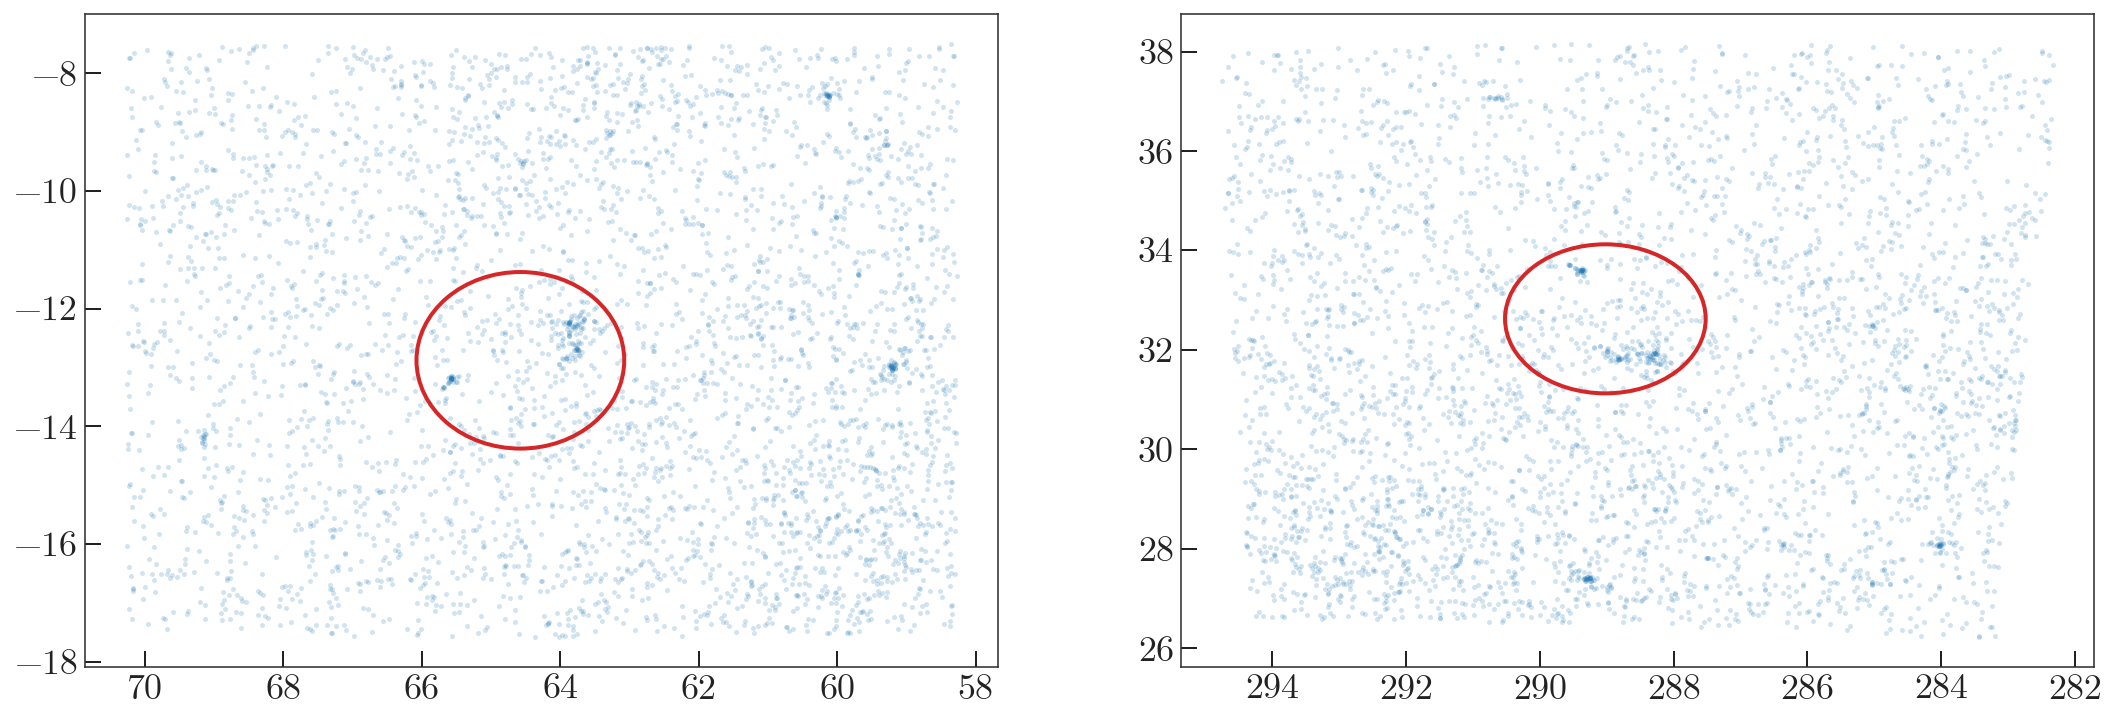

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

ax = axes[0]
ax.plot(mag_c.L, mag_c.B, marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_mag_c.L.degree, cluster_mag_c.B.degree),
                                radius=1.5, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

ax = axes[1]
ax.plot(mag_c.galactic.l, mag_c.galactic.b, 
        marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_c.galactic.l.degree, 
                                 cluster_c.galactic.b.degree),
                                radius=1.5, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

In [57]:
tbl = Table()
tbl['bprp'] = BPRP[bprp_mask]
tbl['G'] = G0[bprp_mask]

for col in g.data.colnames:
    tbl[col] = g.data[col]
tbl.write('/Users/adrian/Downloads/test-phot.fits', overwrite=True)

In [37]:
seed_locs = coord.SkyCoord(L=[cluster_mag_c.L.degree,
                              cluster_mag_c.L.degree]*u.deg,
                           B=[cluster_mag_c.B.degree + 2.6,
                              cluster_mag_c.B.degree - 2.6]*u.deg,
                           frame=gc.MagellanicStream)

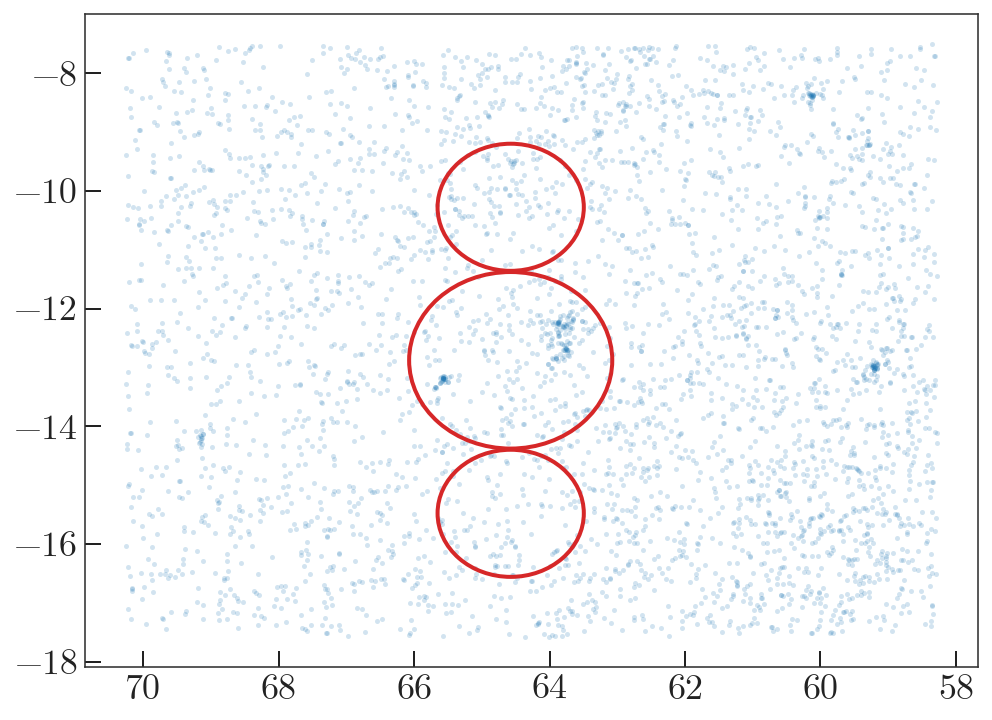

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(mag_c.L, mag_c.B, marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_mag_c.L.degree, cluster_mag_c.B.degree),
                                radius=1.5, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

for seed in seed_locs:
    ax.add_patch(mpl.patches.Circle((seed.L.degree, seed.B.degree),
                                     radius=1.08, facecolor='none', 
                                     edgecolor='tab:red', zorder=100, linewidth=2))

In [39]:
control_mask = np.zeros(len(g)).astype(bool)
for seed in seed_locs:
    control_mask |= seed.separation(c) < 1.08*u.deg

In [40]:
cluster_mask = c.separation(cluster_c) < 1.5*u.deg

In [41]:
control_mask.sum(), cluster_mask.sum()

(242, 347)

In [42]:
X_co = np.vstack((g.pmra.value, g.pmdec.value)).T[control_mask]
X_cl = np.vstack((g.pmra.value, g.pmdec.value)).T[cluster_mask]

Cov_co = g[control_mask].get_cov()[:, 3:5, 3:5]
Cov_cl = g[cluster_mask].get_cov()[:, 3:5, 3:5]

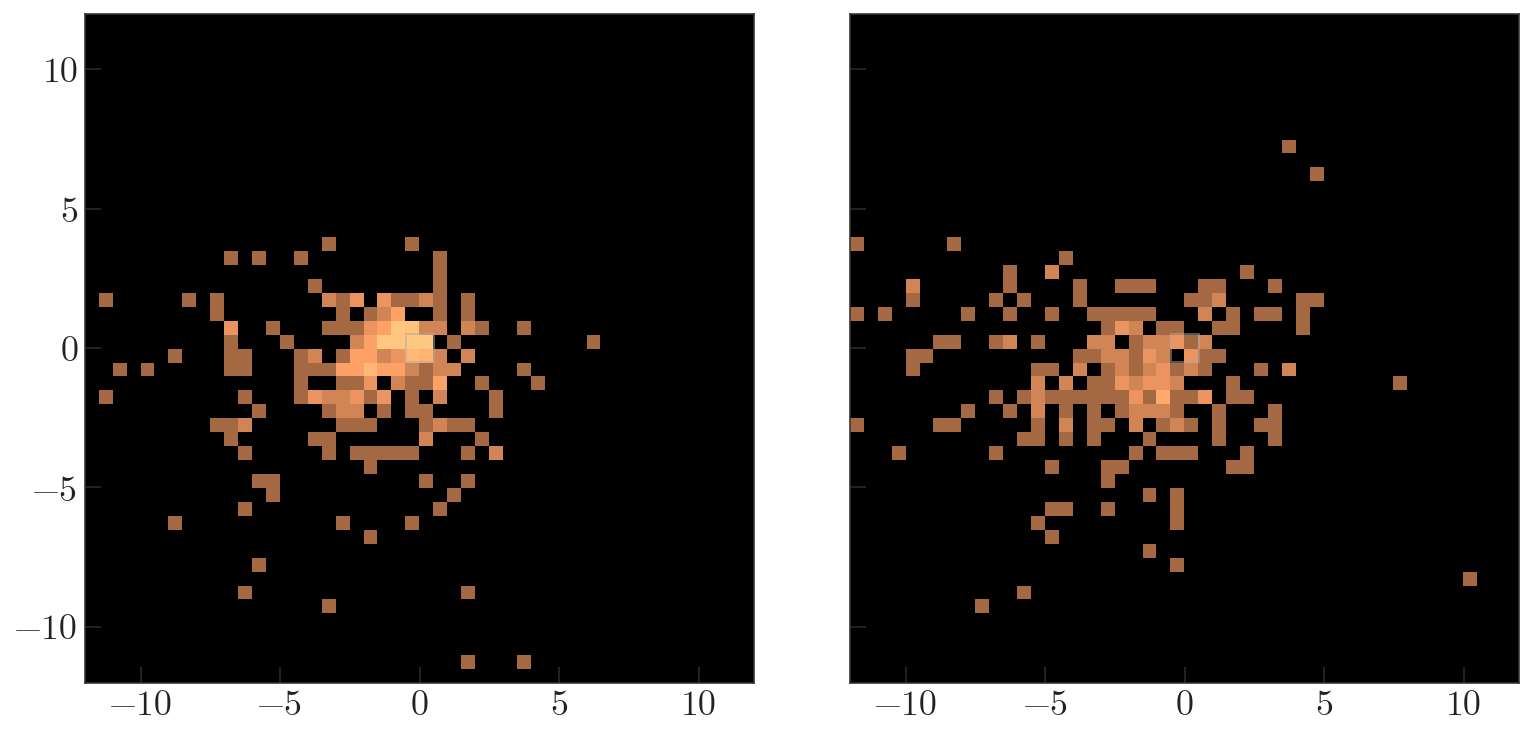

In [74]:
bins = np.arange(-12, 12+1e-3, 0.5)

H_cl, xe, ye = np.histogram2d(X_cl[:, 0], X_cl[:, 1],
                              bins=bins)

H_co, xe, ye = np.histogram2d(X_co[:, 0], X_co[:, 1],
                              bins=bins)

fig, axes = plt.subplots(1, 2, figsize=(11, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H_cl.T + 0.1, cmap='copper', 
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=10))

ax = axes[1]
ax.pcolormesh(xe, ye, H_co.T + 0.1, cmap='copper',
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=10))


for ax in axes:
    ax.set_aspect('equal')
    ax.add_patch(mpl.patches.Rectangle((-0.5, -0.5), 1, 1,
                                       facecolor='none', edgecolor='#aaaaaa',
                                       alpha=0.5, zorder=100))

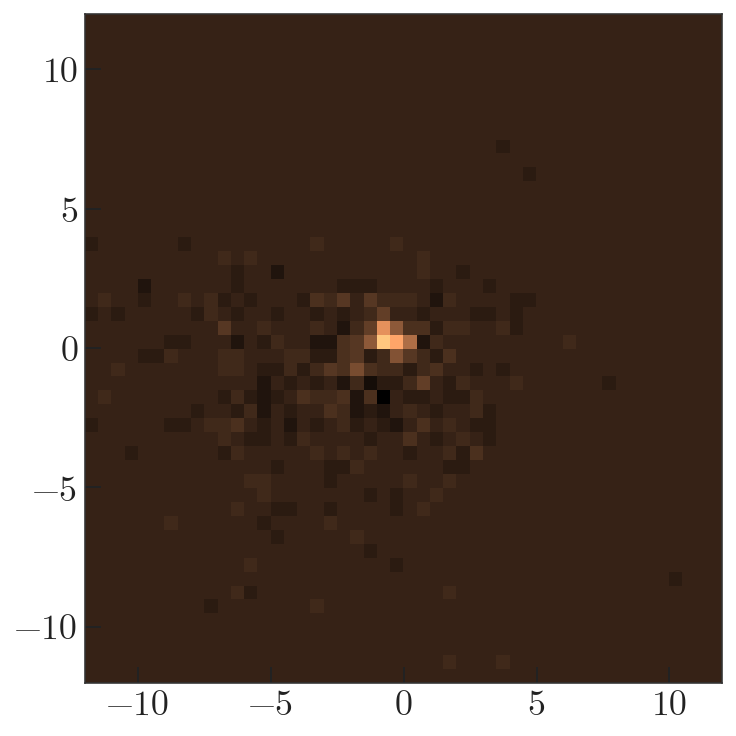

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), 
                       constrained_layout=True)
ax.pcolormesh(xe, ye, (H_cl - H_co).T, cmap='copper')

## Extreme deconvolution

First use heuristics to determine number of components:

In [50]:
xdgmm = XDGMM()

param_range = np.arange(1, 8+1, 1)

# Loop over component numbers, fitting XDGMM model and computing the BIC:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X_co, Cov_co, param_range)

/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 1 , BIC = 2688.12223205


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 2 , BIC = 2511.60279573


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 3 , BIC = 2525.42196457


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 4 , BIC = 2535.4728095


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 5 , BIC = 2560.40134507


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 6 , BIC = 2566.67736889


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 7 , BIC = 2600.10252153


/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

N = 8 , BIC = 2628.31237031


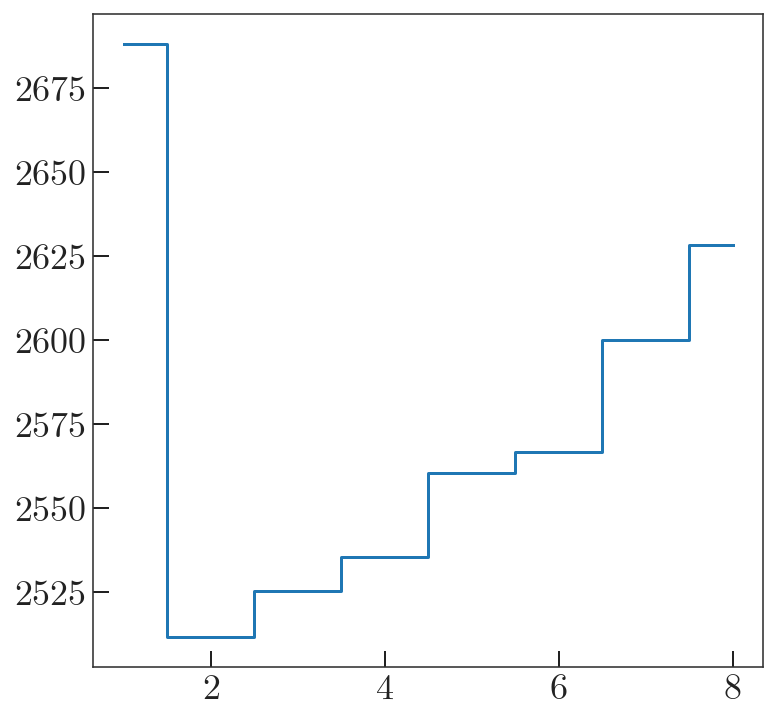

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(param_range, bic, marker='', drawstyle='steps-mid')
# ax.xaxis.set_ticks(param_range)

In [53]:
gmm = XDGMM(n_components=optimal_n_comp, method='Bovy')
_ = gmm.fit(X_co, Cov_co)

In [58]:
test = gmm.sample(size=1000000)

In [136]:
def ln_likelihood(p, gmm, X, Cov):
    x, y, lns, lnf = p
    s = np.exp(lns)
    f = np.exp(lnf)
    sup = XDGMM(n_components=1, method='Bovy', 
                mu=np.array([[x, y]]),
                V=np.array([[[s, 0],
                             [0, s]]]) ** 2,
                weights=np.array([1.]))
    
    ll1 = gmm.logL(X, Cov) + np.log(1-f)
    ll2 = sup.logL(X, Cov) + np.log(f)
    
    print(ll1, ll2)
    
    return np.logaddexp(ll1, ll2)

In [127]:
from scipy.optimize import minimize

In [157]:
p0 = (-0.6, 0.3, np.log(1.), np.log(0.2))
# res = minimize(lambda *args, **kwargs: -ln_likelihood(*args, **kwargs),
#                x0=p0, args=(gmm, X_cl, Cov_cl), method='L-BFGS-B')

In [161]:
sup = XDGMM(n_components=1, method='Bovy', 
                mu=np.array([[-0.6, 0.3]]),
                V=np.array([[[0.2, 0],
                             [0, 0.2]]]) ** 2,
                weights=np.array([1.]))
derp = sup.sample(size=100000)

(-15, 15)

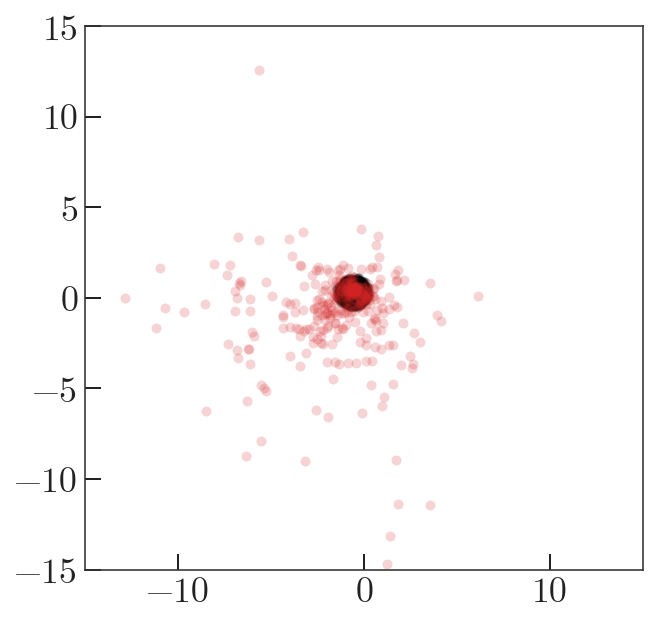

In [162]:
plt.figure(figsize=(5, 5))
plt.scatter(derp[:, 0], derp[:, 1], color='k', 
            alpha=0.2, linewidth=0)
plt.scatter(X_cl[:, 0], X_cl[:, 1], color='tab:red', 
            alpha=0.2, linewidth=0)
plt.xlim(-15, 15)
plt.ylim(-15, 15)

In [172]:
V1 = np.array([[0.2,0],[0,0.2]])**2
V2 = np.array([[0.8,0],[0,0.8]])**2
VV = V1 + V2
test_X = np.random.multivariate_normal(p0[:2], cov=VV, size=(1000,))
test_V = np.repeat(V2[None], 1000, axis=0)

In [177]:
ln_likelihood([-0.6, 0.3, np.log(0.2), np.log(1-1e-5)], gmm, test_X, test_V)

-3541.18917714 -2507.22303626


-2507.223036262912

In [193]:
sup.logL(X_cl[:4], Cov_cl[:4])

-458.15914990098236

In [183]:
pp = [-0.6, 0.3, np.log(0.2), np.log(1-g1e-5)]
vals = np.linspace(-1, 0, 32)
lls = []
for val in vals:
    pp[0] = val
    ll = ln_likelihood(pp, gmm, X_co, Cov_co)
    # ll = ln_likelihood(pp, gmm, test_X, test_V)
    lls.append(ll)
lls = np.array(lls)

-1076.58511925 -30688.9012285
-1076.58511925 -30809.4917352
-1076.58511925 -30931.2896749
-1076.58511925 -31054.2950478
-1076.58511925 -31178.5078539
-1076.58511925 -31303.9280931
-1076.58511925 -31430.5557654
-1076.58511925 -31558.3908708
-1076.58511925 -31687.4334094
-1076.58511925 -31817.6833811
-1076.58511925 -31949.1407859
-1076.58511925 -32081.8056239
-1076.58511925 -32215.677895
-1076.58511925 -32350.7575992
-1076.58511925 -32487.0447366
-1076.58511925 -32624.5393071
-1076.58511925 -32763.2413107
-1076.58511925 -32903.1507474
-1076.58511925 -33044.2676173
-1076.58511925 -33186.5919204
-1076.58511925 -33330.1236565
-1076.58511925 -33474.8628258
-1076.58511925 -33620.8094282
-1076.58511925 -33767.9634638
-1076.58511925 -33916.3249325
-1076.58511925 -34065.8938343
-1076.58511925 -34216.6701692
-1076.58511925 -34368.6539373
-1076.58511925 -34521.8451385
-1076.58511925 -34676.2437729
-1076.58511925 -34831.8498404
-1076.58511925 -34988.663341


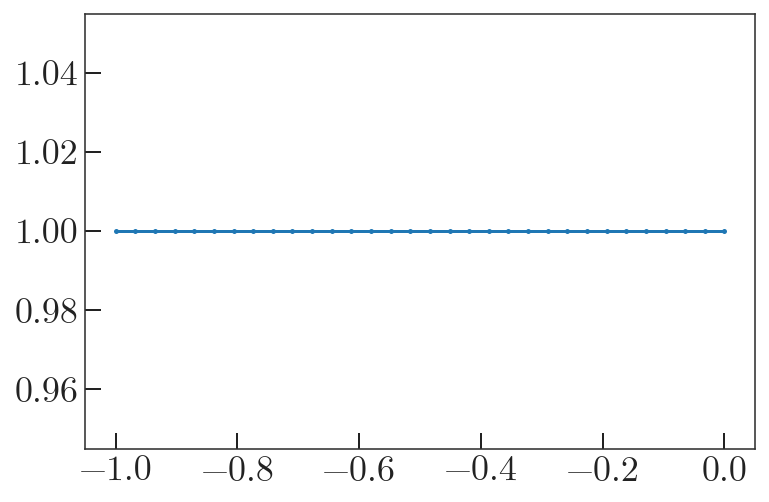

In [184]:
plt.plot(vals, np.exp(lls - lls.max()))